## 6 class AD PD model

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklvq import GMLVQ
from timeit import timeit
from sklearn.model_selection import KFold
from itertools import chain
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    cross_val_score,
    RepeatedKFold,
)
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve,roc_auc_score,auc
import colorama
from colorama import Fore, Style
matplotlib.rc("xtick", labelsize="small")
matplotlib.rc("ytick", labelsize="small")

In [2]:
def getdata():
    data = pd.read_csv("feature_vectors.csv").to_numpy()
    labels = pd.read_csv("diagnosis_label.csv").to_numpy().squeeze()
    labelscenter = pd.read_csv("center_label.csv").to_numpy().squeeze()

    labelsfinal = labels + labelscenter
    
    # better way to perform this
    labelsdiseases1 = np.where(labelsfinal == 'HCUMCG') 
    centerlabels1 = labelsfinal[labelsdiseases1]
    labelsdiseases2 = np.where(labelsfinal == 'HCUGOSM') 
    #labelsdiseases = np.where(labels == 'HCCUN','1',centerlabels) 
    centerlabels2 = labelsfinal[labelsdiseases2]
    labelsdiseases3 = np.where(labelsfinal == 'HCCUN') 
    centerlabels3 = labelsfinal[labelsdiseases3]
    
    # better way to perform this
    centerlabels = np.concatenate((centerlabels1,centerlabels2,centerlabels3))
    centerdata = data[labelsdiseases1]
    centerdata = np.concatenate((centerdata,data[labelsdiseases2]))
    centerdata = np.concatenate((centerdata,data[labelsdiseases3]))
    
    scalar = StandardScaler()
    #data = ztransform(data,scaler)
    #centerdata= ztransform(centerdata,scaler)
    return data,labels,centerdata,centerlabels,labelscenter,scalar

In [3]:
def ztransform(data_ztransform,scalarz):
    # Sklearn's standardscaler to perform z-transform

    # Compute (fit) and apply (transform) z-transform
    # why do we do an inverse z transform
    #scalar = scalar
    data_ztransform = scalarz.fit_transform(data_ztransform)
    
    return data_ztransform,scalarz

In [4]:
class ProcessLogger:
    def __init__(self):
        self.states = np.array([])

    # A callback function has to accept two arguments, i.e., model and state, where model is the
    # current model, and state contains a number of the optimizers variables.
    def __call__(self, state):
        self.states = np.append(self.states, state)
        return False  # The callback function can also be used to stop training early,
        # if some condition is met by returning True.

        
        
logger = ProcessLogger()



In [5]:
def model_definition_center():
    
    model = GMLVQ(
    distance_type="adaptive-squared-euclidean",
    activation_type="sigmoid",
    activation_params={"beta": 2},
        #wgd
    solver_type="wgd",
    solver_params={"max_runs": 50,"step_size": np.array([0.1, 0.05]),"callback": logger},
    #solver_params={"max_runs": 10,"batch_size":1,"step_size": np.array([0.1, 0.05])},
    random_state=1428,)
    
    return model

In [6]:
def model_definition_disease(correctionmatrix):
    model1 = GMLVQ(
        distance_type="adaptive-squared-euclidean",
        activation_type="sigmoid",
        activation_params={"beta": 2},
        solver_type="wgd",
        solver_params={"max_runs": 50,"step_size": np.array([0.1, 0.05]),"callback": logger},
        #solver_params={"max_runs": 10,"batch_size":1,"step_size": np.array([0.1, 0.05])},
        random_state=1428,
        relevance_correction=correctionmatrix
    )
    return model1

In [7]:
#run the whole notebook for max runs say(1-10000) # check exactly what does max runs define in this. calculate the loss and store at each max runs step

In [8]:
def train_modelkfold(data, label,disease,correctionmatrix1,repeated,scalar,folds=5):
    modelmatrix = np.zeros((repeated,folds),dtype=object) 
    scalars = np.zeros((repeated,folds),dtype=object)
    datamatrix =  np.zeros((repeated,folds),dtype=object) 
    labelmatrix = np.zeros((repeated,folds),dtype=object)
    accuracies = np.zeros((repeated,folds),dtype=float) 
    # each entry will store the test labels and the predicted labels
    testlabels = np.zeros((repeated,folds),dtype=object) 
    predicted = np.zeros((repeated,folds),dtype=object) 
    probablities = np.zeros((repeated,folds),dtype=object) 
    laeblscore = np.zeros((repeated,folds),dtype=object) 
    testing_indicesM = np.zeros((repeated,folds),dtype=object) 
    traning_indicesM = np.zeros((repeated,folds),dtype=object) 
    
    if disease==False:
        print('Repeated K fold for center data')
    else:
        print('Repeated K fold for disease data')
    for repeated in range(repeated):
        
        print("========Repeated fold number",str(repeated),"========")
        kfold = KFold(folds, shuffle=True)
        
        for k, (training_indices, testing_indices) in enumerate(kfold.split(data)):
            if disease==False:
                model = model_definition_center()
                #print('in this')
                #print(type(model))
            else:
                #model = model_definition_center()
                model = model_definition_disease(correctionmatrix1)
            accuracy = 0
            correct = 0
            trainX, trainY, testX, testY = data[training_indices], label[training_indices], data[testing_indices], label[testing_indices]
            #applying z transform on training data only
            trainX,scalar1 = ztransform(trainX,scalar)
            model.fit(trainX,trainY)
            
            # model is fitted, can also do = model
            modelmatrix[repeated,k] = model
            datamatrix[repeated,k] = trainX
            
            
            labelmatrix[repeated,k] = trainY

            testX = scalar1.transform(testX)
            predictedlabels = model.predict(testX)
            #print(confusion_matrix(testX, predictedlabels))
            for i in range(len(predictedlabels)):
                if(predictedlabels[i]==testY[i]):
                    correct = correct+1
                    
            scalars[repeated,k] = scalar1
            
            probabilties = model.predict_proba(testX)
            
            laeblscore[repeated,k] = model.decision_function(testX)
            
            probablities[repeated,k] = probabilties
            
            testlabels[repeated,k] = testY
            
            predicted[repeated,k] = predictedlabels
            
            
            testing_indicesM[repeated,k] = testing_indices
            traning_indicesM[repeated,k] = training_indices
            
            accuracy = correct/len(testY)
            print('%.3f accuracy' % (correct/len(testY)))
    return modelmatrix,datamatrix,labelmatrix,scalars,testlabels,predicted,probablities,laeblscore,testing_indicesM,traning_indicesM

In [9]:
def calculate_lambda(modelmatrix,repeated):
    #average_lambda = np.mean(sum(model.lambda_ for model in modellist),axis=0)
    #check the shape of total_lambda
    
    total_lambda = np.zeros((36,36),dtype = 'float')
    print(repeated)
    for index in range(repeated):
        print(index)
        lambdaperfold = np.zeros((36,36),dtype='float')        
        
        for modelin in modelmatrix[index,:]:
            lambdaperfold = lambdaperfold + modelin.lambda_

        lambdaperfold = lambdaperfold/np.shape(modelmatrix)[1]
        
        total_lambda = total_lambda + lambdaperfold
        
    total_lambda = total_lambda/repeated

    return total_lambda

In [10]:
def eigendecomposition(average_lambda):
    eigenvalues, eigenvectors = np.linalg.eigh(average_lambda)
    # eigen vectors returned in columns
    # Flip (reverse the order to descending) before assigning.
    eigenvalues = np.flip(eigenvalues)

    # eigenvectors are column matrix in ascending order. Flip the columns and transpose the matrix
    # to get the descending ordered row matrix.
    
    # eigenvectors are row matrices
    eigenvectors = np.flip(eigenvectors, axis=1).T
    
    return eigenvalues,eigenvectors

In [11]:
feature_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','ab','ac','ad','ae','af','ag','ah','ai','aj','ak']


In [12]:

def correction_matrix(eigvectorscenter):
    N=36
    K=1
    I = np.identity(N)
    outerproduct = np.zeros((N,N))   
    for i in range(K):
        # check this
        outerproduct +=  np.outer(eigvectorscenter.T[:,i],eigvectorscenter[i,:])
        outerproduct1 =  np.outer(eigvectorscenter.T[:,0],eigvectorscenter[0,:])
        outerproduct2 =  np.outer(eigvectorscenter.T[:,1],eigvectorscenter[1,:])        
    correctionmatrix = I-outerproduct
    return correctionmatrix

In [13]:
def calculate_prototype(modelmatrix,repeated,dimension,scalarmodel):
    #prototypeaverage = np.zeros((prototype,dimensions),dtype='float')    
    numberofprototypes = len(modelmatrix[0][0].prototypes_)
    prototypeaverage = np.zeros((numberofprototypes,dimension),dtype='float')    
    modellist = list(chain.from_iterable(zip(*modelmatrix)))
    scalarlist = list(chain.from_iterable(zip(*scalarmodel)))
    for modelin in range(len(modellist)):
        for i in range(numberofprototypes):
            #prototypeaverage[i] = np.add(prototypeaverage[i],scalarlist[i].inverse_transform(modellist[modelin].prototypes_[i]))
            prototypeaverage[i] = np.add(prototypeaverage[i],scalarlist[modelin].inverse_transform(modellist[modelin].prototypes_[i]))
    return prototypeaverage/len(modellist)

In [14]:
def calculate_prototype1(modelmatrix,repeated,dimension,scalarmodel):
    #prototypeaverage = np.zeros((prototype,dimensions),dtype='float')    
    numberofprototypes = len(modelmatrix[0][0].prototypes_)
    prototypeaverage = np.zeros((numberofprototypes,dimension),dtype='float')    
    modellist = list(chain.from_iterable(zip(*modelmatrix)))
    scalarlist = list(chain.from_iterable(zip(*scalarmodel)))
    for modelin in range(len(modellist)):
        for i in range(numberofprototypes):
            #prototypeaverage[i] = np.add(prototypeaverage[i],scalarlist[modelin].inverse_transform(modellist[modelin].prototypes_[i]))
            prototypeaverage[i] = np.add(prototypeaverage[i],scalarlist[modelin].inverse_transform(modellist[modelin].prototypes_[i]))
    return prototypeaverage/len(modellist)

## get data

In [15]:
#data,labels,centerdata,centerlabels,labelscenter,scalar = getdata()
##################individual model######################################
data,labels,centerdata1,centerlabels1,labelscenter,scalar = getdata()

healthycontrolindices = np.where(labels=='HC')

datanoHC = np.delete(data,healthycontrolindices,axis=0)

labelsnoHC = np.delete(labels,healthycontrolindices,axis=0)

labelscenternoHC = np.delete(labelscenter,healthycontrolindices,axis=0)

labels4class = labelsnoHC + labelscenternoHC
#######################################################################

In [ ]:
repeated = 100
folds = 10

## center data fitting (3 class)

In [16]:


centermodel,datamatrix,labelmatrix,scalars1,testlabelsc,predictedc,probabiltiesc,laeblscorec,testing_indicesC,training_indicesC = train_modelkfold(centerdata1,centerlabels1,False,None,repeated,scalar,folds)

average_lambda_center = calculate_lambda(centermodel,repeated)

average_prototype_center = calculate_prototype(centermodel,repeated,36,scalars1)

print('                                                     ')


print('The sum of the digonal of the center relevance matrix')

print(np.sum(np.diagonal(average_lambda_center)))

print('                                                     ')


eigenvaluescenter,eigenvectorscenter = eigendecomposition(average_lambda_center)


correctionmatrix1 = correction_matrix(eigenvectorscenter)

#correctionmatrix = correction_matrix()


Repeated K fold for center data
========Repeated fold number 0 ========
0.941 accuracy
0.882 accuracy
0.875 accuracy
1.000 accuracy
0.875 accuracy
========Repeated fold number 1 ========
0.882 accuracy
0.882 accuracy
0.938 accuracy
0.875 accuracy
0.875 accuracy
========Repeated fold number 2 ========
0.882 accuracy
0.882 accuracy
0.938 accuracy
0.938 accuracy
0.938 accuracy
========Repeated fold number 3 ========
1.000 accuracy
0.882 accuracy
1.000 accuracy
0.688 accuracy
0.875 accuracy
========Repeated fold number 4 ========
0.882 accuracy
1.000 accuracy
0.875 accuracy
0.812 accuracy
0.875 accuracy
========Repeated fold number 5 ========
0.824 accuracy
0.882 accuracy
1.000 accuracy
0.938 accuracy
0.938 accuracy
========Repeated fold number 6 ========
0.941 accuracy
0.882 accuracy
1.000 accuracy
1.000 accuracy
0.875 accuracy
========Repeated fold number 7 ========
0.941 accuracy
0.941 accuracy
0.875 accuracy
0.938 accuracy
0.812 accuracy
========Repeated fold number 8 ========
0.824 ac

## Disease data fitting 4 class AD PD

In [17]:

diseasemodel,datamatrix1,labelmatrix1,scalars2,testlabelsd,predictedd,probabiltiesd,laeblscored,testing_indicesD,training_indicesD  = train_modelkfold(datanoHC,labels4class,True,correctionmatrix1,repeated,scalar,folds)

average_lambda_disease = calculate_lambda(diseasemodel,repeated)

# average lambdas corrected not single therefore avereage correction is more efficient
eigenvaluesdisease,eigenvectorsdisease = eigendecomposition(average_lambda_disease)


average_prototype_disease = calculate_prototype1(diseasemodel,repeated,36,scalars2)




print('The sum of the digonal of the disease relevance matrix')

print(np.sum(np.diagonal(average_lambda_disease)))


Repeated K fold for disease data
========Repeated fold number 0 ========
0.780 accuracy
0.780 accuracy
0.680 accuracy
0.800 accuracy
0.740 accuracy
========Repeated fold number 1 ========
0.820 accuracy
0.820 accuracy
0.640 accuracy
0.800 accuracy
0.720 accuracy
========Repeated fold number 2 ========
0.740 accuracy
0.700 accuracy
0.800 accuracy
0.900 accuracy
0.780 accuracy
========Repeated fold number 3 ========
0.760 accuracy
0.860 accuracy
0.800 accuracy
0.800 accuracy
0.660 accuracy
========Repeated fold number 4 ========
0.780 accuracy
0.740 accuracy
0.840 accuracy
0.780 accuracy
0.800 accuracy
========Repeated fold number 5 ========
0.820 accuracy
0.740 accuracy
0.800 accuracy
0.700 accuracy
0.780 accuracy
========Repeated fold number 6 ========
0.840 accuracy
0.740 accuracy
0.720 accuracy
0.840 accuracy
0.800 accuracy
========Repeated fold number 7 ========
0.740 accuracy
0.780 accuracy
0.760 accuracy
0.680 accuracy
0.740 accuracy
========Repeated fold number 8 ========
0.760 a

## single model trained on 4 class disease and 3 class center data

In [18]:
# training an individual model
data,labels,centerdata1,centerlabels1,labelscenter,scalar = getdata()

modelc = model_definition_center()
centerdata1,scalarIc = ztransform(centerdata1,scalar)

modelc.fit(centerdata1,centerlabels1)

correctionmatrix12 = correction_matrix(modelc.eigenvectors_)
datanoHC,scalarId = ztransform(datanoHC,scalar)

modeld = model_definition_disease(correctionmatrix12)

modeld.fit(datanoHC,labels4class)
predictedlabels = modeld.predict(datanoHC)

## Zero dot product

In [19]:
# removed the influence of the leading eigen vector from each 
first_eigen_vector = np.dot(diseasemodel[0][3].eigenvectors_[0,:],eigenvectorscenter[1,:])
print(first_eigen_vector)

-0.657554533041906


In [20]:
def check_orthogonality(centermodel,diseasemodel,dimensions,repeated,folds,eigenvectorscenter):
    centerlist = list(chain.from_iterable(zip(*centermodel)))
    disease_center = list()
    disease_averagecenter= list()
    for j in range(2):
        for array,modeld in enumerate(diseasemodel[j]):
            disease_averagecenter.append(np.dot(modeld.eigenvectors_[:2,:],eigenvectorscenter[:2,:].T))
            for modelc in centerlist:
                # eigenvectors are row vectors
                disease_center.append((np.dot(modeld.eigenvectors_[:2,:],modelc.eigenvectors_[:2,:].T)))
    return disease_averagecenter,disease_center

In [21]:
def transform1(X,eigenvaluesaverage,eigenvectoraverage,scale):
    eigenvaluesaverage[eigenvaluesaverage < 0] = 0
    eigenvectoraverage = np.sqrt(eigenvaluesaverage[:, None]) * eigenvectoraverage
    if scale == True:
        return np.matmul(X, eigenvectoraverage.T)
    return np.matmul(X, eigenvectoraverage.T)

In [22]:
modeld.classes_

array(['ADUGOSM', 'ADUMCG', 'PDCUN', 'PDUGOSM', 'PDUMCG'], dtype=object)

## confusion matrix 

In [23]:
def confusionmatrix6_class(test,predicted):
    
    #confusion_matrix(test, predicted, labels)
    PDCUN_PDCUN=PDCUN_PDUGOSM=PDCUN_PDUMCG=PDCUN_ADUGOSM=PDCUN_ADUMCG=PDUGOSM_PDCUN=PDUGOSM_PDUGOSM=PDUGOSM_PDUMCG=PDUGOSM_ADUGOSM=PDUGOSM_ADUMCG=PDUMCG_PDCUN=PDUMCG_PDUGOSM=PDUMCG_PDUMCG=PDUMCG_ADUGOSM=PDUMCG_ADUMCG= ADUGOSM_PDCUN=ADUGOSM_PDUGOSM=ADUGOSM_PDUMCG=ADUGOSM_ADUGOSM=ADUGOSM_ADUMCG= ADUMCG_PDCUN=ADUMCG_PDUGOSM=ADUMCG_PDUMCG=ADUMCG_ADUGOSM=ADUMCG_ADUMCG = 0

    PDCUN_PDCUN,PDCUN_PDUGOSM,PDCUN_PDUMCG,PDCUN_ADUGOSM,PDCUN_ADUMCG,\
    PDUGOSM_PDCUN, PDUGOSM_PDUGOSM, PDUGOSM_PDUMCG, PDUGOSM_ADUGOSM, PDUGOSM_ADUMCG,\
    PDUMCG_PDCUN, PDUMCG_PDUGOSM, PDUMCG_PDUMCG, PDUMCG_ADUGOSM, PDUMCG_ADUMCG,\
    ADUGOSM_PDCUN ,ADUGOSM_PDUGOSM ,ADUGOSM_PDUMCG, ADUGOSM_ADUGOSM ,ADUGOSM_ADUMCG,\
    ADUMCG_PDCUN, ADUMCG_PDUGOSM, ADUMCG_PDUMCG, ADUMCG_ADUGOSM,ADUMCG_ADUMCG = confusion_matrix(test, predicted,labels=['PDCUN','PDUGOSM','PDUMCG','ADUGOSM','ADUMCG']).ravel()
    #confusion_matrix(test, predicted,labels=['PDCUN','PDUGOSM','PDUMCG','ADUGOSM','ADUMCG']).ravel()
            
    return PDCUN_PDCUN,PDCUN_PDUGOSM,PDCUN_PDUMCG,PDCUN_ADUGOSM,PDCUN_ADUMCG,\
    PDUGOSM_PDCUN, PDUGOSM_PDUGOSM, PDUGOSM_PDUMCG, PDUGOSM_ADUGOSM, PDUGOSM_ADUMCG,\
    PDUMCG_PDCUN, PDUMCG_PDUGOSM, PDUMCG_PDUMCG, PDUMCG_ADUGOSM, PDUMCG_ADUMCG,\
    ADUGOSM_PDCUN ,ADUGOSM_PDUGOSM ,ADUGOSM_PDUMCG, ADUGOSM_ADUGOSM ,ADUGOSM_ADUMCG,\
    ADUMCG_PDCUN, ADUMCG_PDUGOSM, ADUMCG_PDUMCG, ADUMCG_ADUGOSM, ADUMCG_ADUMCG 
            

In [24]:
def confusionmatrix_61class(modelmatrix,testlabelmatrix,predictedlabelmatrix):
    #testlist = list(chain.from_iterable(zip(*testlabelmatrix)))
    #predictedlist = list(chain.from_iterable(zip(*predictedlabelmatrix)))
    
    testlist = testlabelmatrix
    predictedlist = predictedlabelmatrix
    
    PDCUN_fpr = dict()
    PDCUN_tpr = dict()
    
    PDUGOSM_fpr = dict()
    PDUGOSM_tpr = dict()
    
    PDUMCG_fpr = dict()
    PDUMCG_tpr = dict()
    
    ADUGOSM_fpr = dict()
    ADUGOSM_tpr = dict()
    
    ADUMCG_fpr = dict()
    ADUMCG_tpr = dict()


    PDCUN_PDCUN=PDCUN_PDUGOSM=PDCUN_PDUMCG=PDCUN_ADUGOSM=PDCUN_ADUMCG=\
    PDUGOSM_PDCUN=PDUGOSM_PDUGOSM=PDUGOSM_PDUMCG=PDUGOSM_ADUGOSM=PDUGOSM_ADUMCG=\
    PDUMCG_PDCUN=PDUMCG_PDUGOSM=PDUMCG_PDUMCG=PDUMCG_ADUGOSM=PDUMCG_ADUMCG=\
    ADUGOSM_PDCUN=ADUGOSM_PDUGOSM=ADUGOSM_PDUMCG=ADUGOSM_ADUGOSM=ADUGOSM_ADUMCG=\
    ADUMCG_PDCUN=ADUMCG_PDUGOSM=ADUMCG_PDUMCG=ADUMCG_ADUGOSM=ADUMCG_ADUMCG = 0

    nPDCUN_fpr=nPDCUN_tpr= nPDUGOSM_fpr= nPDUGOSM_tpr= nPDUMCG_fpr= nPDUMCG_tpr= nADUGOSM_fpr= nADUGOSM_tpr= nADUMCG_fpr= nADUMCG_tpr=0
        
        #PDCUN_PDCUN=PDCUN_PDUGOSM=PDCUN_PDUMCG=PDCUN_ADUGOSM=PDCUN_ADUMCG=PDUGOSM_PDCUN=PDUGOSM_PDUGOSM=PDUGOSM_PDUMCG=PDUGOSM_ADUGOSM=PDUGOSM_ADUMCG=PDUMCG_PDCUN=PDUMCG_PDUGOSM=PDUMCG_PDUMCG=PDUMCG_ADUGOSM=PDUMCG_ADUMCG= ADUGOSM_PDCUN=ADUGOSM_PDUGOSM=ADUGOSM_PDUMCG=ADUGOSM_ADUGOSM=ADUGOSM_ADUMCG= ADUMCG_PDCUN=ADUMCG_PDUGOSM=ADUMCG_PDUMCG=ADUMCG_ADUGOSM=ADUMCG_ADUMCG = 0
        
        
        
        
    PDCUN_PDCUN,PDCUN_PDUGOSM,PDCUN_PDUMCG,PDCUN_ADUGOSM,PDCUN_ADUMCG,\
    PDUGOSM_PDCUN, PDUGOSM_PDUGOSM, PDUGOSM_PDUMCG, PDUGOSM_ADUGOSM, PDUGOSM_ADUMCG,\
    PDUMCG_PDCUN, PDUMCG_PDUGOSM, PDUMCG_PDUMCG, PDUMCG_ADUGOSM, PDUMCG_ADUMCG,\
    ADUGOSM_PDCUN, ADUGOSM_PDUGOSM ,ADUGOSM_PDUMCG, ADUGOSM_ADUGOSM ,ADUGOSM_ADUMCG,\
    ADUMCG_PDCUN, ADUMCG_PDUGOSM, ADUMCG_PDUMCG, ADUMCG_ADUGOSM, ADUMCG_ADUMCG = confusionmatrix6_class(testlist,predictedlist)
        
    nPDCUN_fpr = (PDUGOSM_PDCUN + PDUMCG_PDCUN + ADUGOSM_PDCUN + ADUMCG_PDCUN)/( PDUGOSM_PDCUN + PDUMCG_PDCUN + ADUGOSM_PDCUN + ADUMCG_PDCUN+\
                                                                                PDUGOSM_PDUGOSM+ PDUGOSM_PDUMCG+ PDUGOSM_ADUGOSM+PDUGOSM_ADUMCG+\
                                                                                +PDUMCG_PDUGOSM+PDUMCG_PDUMCG+PDUMCG_ADUGOSM+PDUMCG_ADUMCG+\
                                                                                ADUGOSM_PDUGOSM+ADUGOSM_PDUMCG+ADUGOSM_ADUGOSM+ADUGOSM_ADUMCG+\
                                                                                ADUMCG_PDUGOSM+ADUMCG_PDUMCG+ADUMCG_ADUGOSM+ADUMCG_ADUMCG)



    nPDCUN_tpr = (PDCUN_PDCUN)/(PDCUN_PDCUN+PDCUN_PDUGOSM+PDCUN_PDUMCG+PDCUN_ADUGOSM+PDCUN_ADUMCG)

    ##############################
    nPDUGOSM_fpr = (PDCUN_PDUGOSM+PDUMCG_PDUGOSM+ ADUGOSM_PDUGOSM + ADUMCG_PDUGOSM) / (PDCUN_PDUGOSM+PDUMCG_PDUGOSM+ ADUGOSM_PDUGOSM + ADUMCG_PDUGOSM+\
                                                                                     PDCUN_PDCUN+PDCUN_PDUMCG+PDCUN_ADUGOSM+PDCUN_ADUMCG+\
                                                                                  PDUMCG_PDCUN+PDUMCG_PDUMCG+PDUMCG_ADUGOSM+PDUMCG_ADUMCG+\
                                                                                  ADUGOSM_PDCUN+ADUGOSM_PDUMCG+ADUGOSM_ADUGOSM+ADUGOSM_ADUMCG+\
                                                                                ADUMCG_PDCUN+ADUMCG_PDUMCG+ADUMCG_ADUGOSM+ADUMCG_ADUMCG)

    nPDUGOSM_tpr = (PDUGOSM_PDUGOSM)/ (PDUGOSM_PDUGOSM+PDUGOSM_PDCUN+PDUGOSM_PDUMCG+PDUGOSM_ADUGOSM+PDUGOSM_ADUMCG)

    ##############################


    nPDUMCG_fpr = (PDCUN_PDUMCG+PDUGOSM_PDUMCG+ADUGOSM_PDUMCG+ADUMCG_PDUMCG)/(PDCUN_PDUMCG+PDUGOSM_PDUMCG+ADUGOSM_PDUMCG+ADUMCG_PDUMCG+\
                                                                             PDCUN_PDCUN+PDCUN_PDUGOSM+PDCUN_ADUGOSM+PDCUN_ADUMCG+\
                                                                             PDUGOSM_PDCUN+PDUGOSM_PDUGOSM+PDUGOSM_ADUGOSM+PDUGOSM_ADUMCG+\
                                                                             ADUGOSM_PDCUN+ADUGOSM_PDUGOSM+ADUGOSM_ADUGOSM+ADUGOSM_ADUMCG+\
                                                                             ADUMCG_PDCUN+ADUMCG_PDUGOSM+ADUMCG_ADUGOSM+ADUMCG_ADUMCG)


    nPDUMCG_tpr = PDUMCG_PDUMCG/(PDUMCG_PDCUN+PDUMCG_PDUGOSM+PDUMCG_PDUMCG+PDUMCG_ADUGOSM+PDUMCG_ADUMCG)

    ##############################

    nADUGOSM_fpr = (PDCUN_ADUGOSM+PDUGOSM_ADUGOSM+PDUMCG_ADUGOSM+ADUMCG_ADUGOSM) / (PDCUN_ADUGOSM+PDUGOSM_ADUGOSM+PDUMCG_ADUGOSM+ADUMCG_ADUGOSM+\
                                                                                PDCUN_PDCUN+PDCUN_PDUGOSM+PDCUN_PDUMCG+PDCUN_ADUMCG+\
                                                                                PDUGOSM_PDCUN+PDUGOSM_PDUGOSM+PDUGOSM_PDUMCG+PDUGOSM_ADUMCG+\
                                                                                PDUMCG_PDCUN+PDUMCG_PDUGOSM+PDUMCG_PDUMCG+PDUMCG_ADUMCG+\
                                                                                ADUMCG_PDCUN+ADUMCG_PDUGOSM+ADUMCG_PDUMCG+ADUMCG_ADUMCG)

    nADUGOSM_tpr = (ADUGOSM_ADUGOSM)/(ADUGOSM_ADUGOSM + ADUGOSM_PDCUN+ ADUGOSM_PDUGOSM+ADUGOSM_PDUMCG+ADUGOSM_ADUMCG)
    #############################


    nADUMCG_fpr = (PDCUN_ADUMCG+PDUGOSM_ADUMCG+PDUMCG_ADUMCG+ADUGOSM_ADUMCG)/(PDCUN_ADUMCG + PDUGOSM_ADUMCG+PDUMCG_ADUMCG+ADUGOSM_ADUMCG+\
                                                                                    PDCUN_PDCUN + PDCUN_PDUGOSM+PDCUN_PDUMCG+PDCUN_ADUGOSM+\
                                                                                    PDUGOSM_PDCUN+ PDUGOSM_PDUGOSM+PDUGOSM_PDUMCG+PDUGOSM_ADUGOSM+\
                                                                                    PDUMCG_PDCUN+ PDUMCG_PDUGOSM+PDUMCG_PDUMCG+PDUMCG_ADUGOSM+\
                                                                                    ADUGOSM_PDCUN+ADUGOSM_PDUGOSM+ADUGOSM_PDUMCG+ADUGOSM_ADUGOSM)

    #print(PDCUN_ADUMCG+PDUGOSM_ADUMCG+PDUMCG_ADUMCG+ADUGOSM_ADUMCG)
    #print(PDCUN_ADUMCG + PDUGOSM_ADUMCG + PDUMCG_ADUMCG + ADUGOSM_ADUMCG + PDCUN_PDCUN + PDCUN_PDUGOSM+PDCUN_PDUMCG + PDCUN_ADUGOSM + PDUGOSM_PDCUN + PDUGOSM_PDUGOSM + PDUGOSM_PDUMCG + PDUGOSM_ADUGOSM + PDUMCG_PDCUN + PDUMCG_PDUGOSM + PDUMCG_PDUMCG + PDUMCG_ADUGOSM + ADUGOSM_PDCUN + ADUGOSM_PDUGOSM + ADUGOSM_PDUMCG + ADUGOSM_ADUGOSM)

    nADUMCG_tpr = (ADUMCG_ADUMCG) /(ADUMCG_PDCUN+ ADUMCG_PDUGOSM+ ADUMCG_PDUMCG+ ADUMCG_ADUGOSM+ ADUMCG_ADUMCG)
    #############################
    PDCUN_fpr = (nPDCUN_fpr)
    PDCUN_tpr = (nPDCUN_tpr)

    PDUGOSM_fpr =(nPDUGOSM_fpr)
    PDUGOSM_tpr =(nPDUGOSM_tpr)

    PDUMCG_fpr =(nPDUMCG_fpr)
    PDUMCG_tpr =(nPDUMCG_tpr)

    ADUGOSM_fpr =(nADUGOSM_fpr)
    ADUGOSM_tpr =(nADUGOSM_tpr)

    ADUMCG_fpr = (nADUMCG_fpr)
    ADUMCG_tpr = (nADUMCG_tpr)
    # add to the dictionary
    #pd_fpr[i].append(npd_fpr)
    #pd_tpr[i].append(npd_tpr)
    #ad_fpr[i].append(nad_fpr)
    #ad_tpr[i].append(nad_tpr)

#return PDCUN_PDCUN,PDCUN_PDUGOSM,PDCUN_PDUMCG,PDCUN_ADUGOSM,PDCUN_ADUMCG,PDUGOSM_PDCUN, PDUGOSM_PDUGOSM, PDUGOSM_PDUMCG, PDUGOSM_ADUGOSM, PDUGOSM_ADUMCG,PDUMCG_PDCUN, PDUMCG_PDUGOSM, PDUMCG_PDUMCG, PDUMCG_ADUGOSM, PDUMCG_ADUMCG,ADUGOSM_PDCUN ,ADUGOSM_PDUGOSM ,ADUGOSM_PDUMCG, ADUGOSM_ADUGOSM ,ADUGOSM_ADUMCG,ADUMCG_PDCUN, ADUMCG_PDUGOSM, ADUMCG_PDUMCG, ADUMCG_ADUGOSM, ADUMCG_ADUMCG
    return PDCUN_fpr,PDCUN_tpr,PDUGOSM_fpr,PDUGOSM_tpr,PDUMCG_fpr,PDUMCG_tpr,ADUGOSM_fpr,ADUGOSM_tpr,ADUMCG_fpr,ADUMCG_tpr
    

In [25]:
def confusionmatrix_6class(modelmatrix,testlabelmatrix,predictedlabelmatrix):
    testlist = list(chain.from_iterable(zip(*testlabelmatrix)))
    predictedlist = list(chain.from_iterable(zip(*predictedlabelmatrix)))
    
    PDCUN_fpr = dict()
    PDCUN_tpr = dict()
    
    PDUGOSM_fpr = dict()
    PDUGOSM_tpr = dict()
    
    PDUMCG_fpr = dict()
    PDUMCG_tpr = dict()
    
    ADUGOSM_fpr = dict()
    ADUGOSM_tpr = dict()
    
    ADUMCG_fpr = dict()
    ADUMCG_tpr = dict()

    # all are averge rates
    # later might store in a matrix to index exact model
    for i in range(len(testlist)):
        PDCUN_PDCUN=PDCUN_PDUGOSM=PDCUN_PDUMCG=PDCUN_ADUGOSM=PDCUN_ADUMCG=\
        PDUGOSM_PDCUN=PDUGOSM_PDUGOSM=PDUGOSM_PDUMCG=PDUGOSM_ADUGOSM=PDUGOSM_ADUMCG=\
        PDUMCG_PDCUN=PDUMCG_PDUGOSM=PDUMCG_PDUMCG=PDUMCG_ADUGOSM=PDUMCG_ADUMCG=\
        ADUGOSM_PDCUN=ADUGOSM_PDUGOSM=ADUGOSM_PDUMCG=ADUGOSM_ADUGOSM=ADUGOSM_ADUMCG=\
        ADUMCG_PDCUN=ADUMCG_PDUGOSM=ADUMCG_PDUMCG=ADUMCG_ADUGOSM=ADUMCG_ADUMCG = 0
        
        nPDCUN_fpr=nPDCUN_tpr= nPDUGOSM_fpr= nPDUGOSM_tpr= nPDUMCG_fpr= nPDUMCG_tpr= nADUGOSM_fpr= nADUGOSM_tpr= nADUMCG_fpr= nADUMCG_tpr=0
        
        #PDCUN_PDCUN=PDCUN_PDUGOSM=PDCUN_PDUMCG=PDCUN_ADUGOSM=PDCUN_ADUMCG=PDUGOSM_PDCUN=PDUGOSM_PDUGOSM=PDUGOSM_PDUMCG=PDUGOSM_ADUGOSM=PDUGOSM_ADUMCG=PDUMCG_PDCUN=PDUMCG_PDUGOSM=PDUMCG_PDUMCG=PDUMCG_ADUGOSM=PDUMCG_ADUMCG= ADUGOSM_PDCUN=ADUGOSM_PDUGOSM=ADUGOSM_PDUMCG=ADUGOSM_ADUGOSM=ADUGOSM_ADUMCG= ADUMCG_PDCUN=ADUMCG_PDUGOSM=ADUMCG_PDUMCG=ADUMCG_ADUGOSM=ADUMCG_ADUMCG = 0
        
        
        
        
        PDCUN_PDCUN,PDCUN_PDUGOSM,PDCUN_PDUMCG,PDCUN_ADUGOSM,PDCUN_ADUMCG,\
        PDUGOSM_PDCUN, PDUGOSM_PDUGOSM, PDUGOSM_PDUMCG, PDUGOSM_ADUGOSM, PDUGOSM_ADUMCG,\
        PDUMCG_PDCUN, PDUMCG_PDUGOSM, PDUMCG_PDUMCG, PDUMCG_ADUGOSM, PDUMCG_ADUMCG,\
        ADUGOSM_PDCUN, ADUGOSM_PDUGOSM ,ADUGOSM_PDUMCG, ADUGOSM_ADUGOSM ,ADUGOSM_ADUMCG,\
        ADUMCG_PDCUN, ADUMCG_PDUGOSM, ADUMCG_PDUMCG, ADUMCG_ADUGOSM, ADUMCG_ADUMCG = confusionmatrix6_class(testlist[i],predictedlist[i])
        
        nPDCUN_fpr = (PDUGOSM_PDCUN + PDUMCG_PDCUN + ADUGOSM_PDCUN + ADUMCG_PDCUN)/( PDUGOSM_PDCUN + PDUMCG_PDCUN + ADUGOSM_PDCUN + ADUMCG_PDCUN+\
                                                                                    PDUGOSM_PDUGOSM+ PDUGOSM_PDUMCG+ PDUGOSM_ADUGOSM+PDUGOSM_ADUMCG+\
                                                                                    +PDUMCG_PDUGOSM+PDUMCG_PDUMCG+PDUMCG_ADUGOSM+PDUMCG_ADUMCG+\
                                                                                    ADUGOSM_PDUGOSM+ADUGOSM_PDUMCG+ADUGOSM_ADUGOSM+ADUGOSM_ADUMCG+\
                                                                                    ADUMCG_PDUGOSM+ADUMCG_PDUMCG+ADUMCG_ADUGOSM+ADUMCG_ADUMCG)
        
        
        nPDCUN_tpr = (PDCUN_PDCUN)/(PDCUN_PDCUN+PDCUN_PDUGOSM+PDCUN_PDUMCG+PDCUN_ADUGOSM+PDCUN_ADUMCG)
        
        ##############################
        nPDUGOSM_fpr = (PDCUN_PDUGOSM+PDUMCG_PDUGOSM+ ADUGOSM_PDUGOSM + ADUMCG_PDUGOSM) / (PDCUN_PDUGOSM+PDUMCG_PDUGOSM+ ADUGOSM_PDUGOSM + ADUMCG_PDUGOSM+\
                                                                                         PDCUN_PDCUN+PDCUN_PDUMCG+PDCUN_ADUGOSM+PDCUN_ADUMCG+\
                                                                                      PDUMCG_PDCUN+PDUMCG_PDUMCG+PDUMCG_ADUGOSM+PDUMCG_ADUMCG+\
                                                                                      ADUGOSM_PDCUN+ADUGOSM_PDUMCG+ADUGOSM_ADUGOSM+ADUGOSM_ADUMCG+\
                                                                                    ADUMCG_PDCUN+ADUMCG_PDUMCG+ADUMCG_ADUGOSM+ADUMCG_ADUMCG)
            
        nPDUGOSM_tpr = (PDUGOSM_PDUGOSM)/ (PDUGOSM_PDUGOSM+PDUGOSM_PDCUN+PDUGOSM_PDUMCG+PDUGOSM_ADUGOSM+PDUGOSM_ADUMCG)
        
        ##############################
        
        
        nPDUMCG_fpr = (PDCUN_PDUMCG+PDUGOSM_PDUMCG+ADUGOSM_PDUMCG+ADUMCG_PDUMCG)/(PDCUN_PDUMCG+PDUGOSM_PDUMCG+ADUGOSM_PDUMCG+ADUMCG_PDUMCG+\
                                                                                 PDCUN_PDCUN+PDCUN_PDUGOSM+PDCUN_ADUGOSM+PDCUN_ADUMCG+\
                                                                                 PDUGOSM_PDCUN+PDUGOSM_PDUGOSM+PDUGOSM_ADUGOSM+PDUGOSM_ADUMCG+\
                                                                                 ADUGOSM_PDCUN+ADUGOSM_PDUGOSM+ADUGOSM_ADUGOSM+ADUGOSM_ADUMCG+\
                                                                                 ADUMCG_PDCUN+ADUMCG_PDUGOSM+ADUMCG_ADUGOSM+ADUMCG_ADUMCG)
        
        
        nPDUMCG_tpr = PDUMCG_PDUMCG/(PDUMCG_PDCUN+PDUMCG_PDUGOSM+PDUMCG_PDUMCG+PDUMCG_ADUGOSM+PDUMCG_ADUMCG)
        
        ##############################
        
        nADUGOSM_fpr = (PDCUN_ADUGOSM+PDUGOSM_ADUGOSM+PDUMCG_ADUGOSM+ADUMCG_ADUGOSM) / (PDCUN_ADUGOSM+PDUGOSM_ADUGOSM+PDUMCG_ADUGOSM+ADUMCG_ADUGOSM+\
                                                                                    PDCUN_PDCUN+PDCUN_PDUGOSM+PDCUN_PDUMCG+PDCUN_ADUMCG+\
                                                                                    PDUGOSM_PDCUN+PDUGOSM_PDUGOSM+PDUGOSM_PDUMCG+PDUGOSM_ADUMCG+\
                                                                                    PDUMCG_PDCUN+PDUMCG_PDUGOSM+PDUMCG_PDUMCG+PDUMCG_ADUMCG+\
                                                                                    ADUMCG_PDCUN+ADUMCG_PDUGOSM+ADUMCG_PDUMCG+ADUMCG_ADUMCG)
        
        nADUGOSM_tpr = (ADUGOSM_ADUGOSM)/(ADUGOSM_ADUGOSM + ADUGOSM_PDCUN+ ADUGOSM_PDUGOSM+ADUGOSM_PDUMCG+ADUGOSM_ADUMCG)
        #############################
        
        
        nADUMCG_fpr = (PDCUN_ADUMCG+PDUGOSM_ADUMCG+PDUMCG_ADUMCG+ADUGOSM_ADUMCG)/(PDCUN_ADUMCG + PDUGOSM_ADUMCG+PDUMCG_ADUMCG+ADUGOSM_ADUMCG+\
                                                                                        PDCUN_PDCUN + PDCUN_PDUGOSM+PDCUN_PDUMCG+PDCUN_ADUGOSM+\
                                                                                        PDUGOSM_PDCUN+ PDUGOSM_PDUGOSM+PDUGOSM_PDUMCG+PDUGOSM_ADUGOSM+\
                                                                                        PDUMCG_PDCUN+ PDUMCG_PDUGOSM+PDUMCG_PDUMCG+PDUMCG_ADUGOSM+\
                                                                                        ADUGOSM_PDCUN+ADUGOSM_PDUGOSM+ADUGOSM_PDUMCG+ADUGOSM_ADUGOSM)
                        
        #print(PDCUN_ADUMCG+PDUGOSM_ADUMCG+PDUMCG_ADUMCG+ADUGOSM_ADUMCG)
        #print(PDCUN_ADUMCG + PDUGOSM_ADUMCG + PDUMCG_ADUMCG + ADUGOSM_ADUMCG + PDCUN_PDCUN + PDCUN_PDUGOSM+PDCUN_PDUMCG + PDCUN_ADUGOSM + PDUGOSM_PDCUN + PDUGOSM_PDUGOSM + PDUGOSM_PDUMCG + PDUGOSM_ADUGOSM + PDUMCG_PDCUN + PDUMCG_PDUGOSM + PDUMCG_PDUMCG + PDUMCG_ADUGOSM + ADUGOSM_PDCUN + ADUGOSM_PDUGOSM + ADUGOSM_PDUMCG + ADUGOSM_ADUGOSM)

        nADUMCG_tpr = (ADUMCG_ADUMCG) /(ADUMCG_PDCUN+ ADUMCG_PDUGOSM+ ADUMCG_PDUMCG+ ADUMCG_ADUGOSM+ ADUMCG_ADUMCG)
        #############################
        PDCUN_fpr[i] = (nPDCUN_fpr)
        PDCUN_tpr[i] = (nPDCUN_tpr)
    
        PDUGOSM_fpr[i]=(nPDUGOSM_fpr)
        PDUGOSM_tpr[i]=(nPDUGOSM_tpr)
    
        PDUMCG_fpr[i]=(nPDUMCG_fpr)
        PDUMCG_tpr[i]=(nPDUMCG_tpr)
    
        ADUGOSM_fpr[i]=(nADUGOSM_fpr)
        ADUGOSM_tpr[i]=(nADUGOSM_tpr)
    
        ADUMCG_fpr[i]= (nADUMCG_fpr)
        ADUMCG_tpr[i]= (nADUMCG_tpr)
        # add to the dictionary
        #pd_fpr[i].append(npd_fpr)
        #pd_tpr[i].append(npd_tpr)
        #ad_fpr[i].append(nad_fpr)
        #ad_tpr[i].append(nad_tpr)
        
    #return PDCUN_PDCUN,PDCUN_PDUGOSM,PDCUN_PDUMCG,PDCUN_ADUGOSM,PDCUN_ADUMCG,PDUGOSM_PDCUN, PDUGOSM_PDUGOSM, PDUGOSM_PDUMCG, PDUGOSM_ADUGOSM, PDUGOSM_ADUMCG,PDUMCG_PDCUN, PDUMCG_PDUGOSM, PDUMCG_PDUMCG, PDUMCG_ADUGOSM, PDUMCG_ADUMCG,ADUGOSM_PDCUN ,ADUGOSM_PDUGOSM ,ADUGOSM_PDUMCG, ADUGOSM_ADUGOSM ,ADUGOSM_ADUMCG,ADUMCG_PDCUN, ADUMCG_PDUGOSM, ADUMCG_PDUMCG, ADUMCG_ADUGOSM, ADUMCG_ADUMCG
    return PDCUN_fpr,PDCUN_tpr,PDUGOSM_fpr,PDUGOSM_tpr,PDUMCG_fpr,PDUMCG_tpr,ADUGOSM_fpr,ADUGOSM_tpr,ADUMCG_fpr,ADUMCG_tpr
    

In [26]:
testlabelsdsingle = np.concatenate(list(chain.from_iterable(zip(*testlabelsd))), axis=0 )
predicteddsingle = np.concatenate( list(chain.from_iterable(zip(*predictedd))), axis=0 )
probabiltysingle = np.concatenate( list(chain.from_iterable(zip(*probabiltiesd))), axis=0 )

## confusion matrix for kfold models

In [27]:
PDCUN_fpr,PDCUN_tpr,PDUGOSM_fpr,PDUGOSM_tpr,PDUMCG_fpr,PDUMCG_tpr,ADUGOSM_fpr,ADUGOSM_tpr,ADUMCG_fpr,ADUMCG_tpr = confusionmatrix_6class(diseasemodel,testlabelsd,predictedd)

PDCUN_fpr1,PDCUN_tpr1,PDUGOSM_fpr1,PDUGOSM_tpr1,PDUMCG_fpr1,PDUMCG_tpr1,ADUGOSM_fpr1,ADUGOSM_tpr1,ADUMCG_fpr1,ADUMCG_tpr1 = confusionmatrix_61class(diseasemodel,testlabelsdsingle,predicteddsingle)

## create dictionary for models and an averaged model

In [28]:
n_classes=['ADUGOSM', 'ADUMCG', 'PDCUN', 'PDUGOSM', 'PDUMCG']
plotdict_tpr1 = dict()
plotdict_fpr1 = dict()
plotdict_tpr1 = ADUGOSM_tpr1,ADUMCG_tpr1,PDCUN_tpr1,PDUGOSM_tpr1,PDUMCG_tpr1
plotdict_fpr1 = ADUGOSM_fpr1,ADUMCG_fpr1,PDCUN_fpr1,PDUGOSM_fpr1,PDUMCG_fpr1

In [29]:
n_classes=['ADUGOSM', 'ADUMCG', 'PDCUN', 'PDUGOSM', 'PDUMCG']
plotdict_tpr = dict()
plotdict_fpr = dict()

#for j in range(len(n_classes)*10):
for j in range(repeated*folds):
    plotdict_tpr[j] = ADUGOSM_tpr[j],ADUMCG_tpr[j],PDCUN_tpr[j],PDUGOSM_tpr[j],PDUMCG_tpr[j]
    plotdict_fpr[j] = ADUGOSM_fpr[j],ADUMCG_fpr[j],PDCUN_fpr[j],PDUGOSM_fpr[j],PDUMCG_fpr[j]

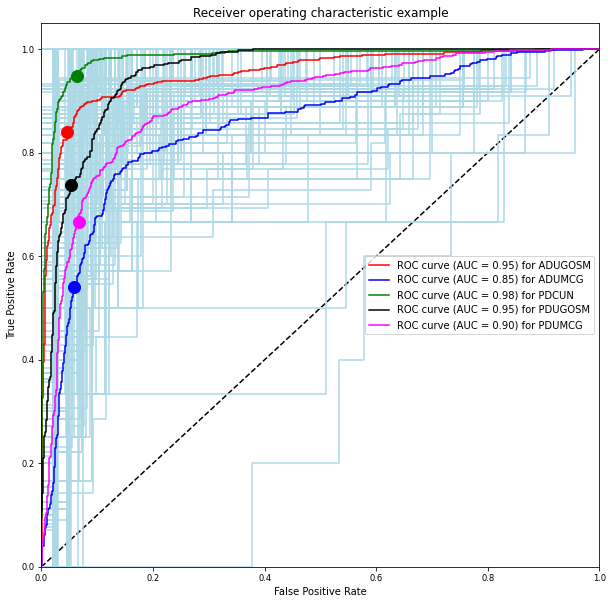

In [30]:
testlist = list(chain.from_iterable(zip(*testlabelsd)))
probabiltylist = list(chain.from_iterable(zip(*probabiltiesd)))
fpru = dict()
tpru = dict()
roc_aucu = dict()
for k in range(len(testlist)):

    n_classes=['ADUGOSM', 'ADUMCG', 'PDCUN', 'PDUGOSM', 'PDUMCG']
    # structures
    fpr = dict()

    tpr = dict()

    roc_auc = dict()
    
    
    
    fpr1 = dict()

    tpr1 = dict()

    roc_auc1 = dict()
    

    colorrange = ['lightblue','lightblue','lightblue','lightblue','lightblue']
    colorrange2 = ['red','blue','green','black','magenta']
    for i in range(len(n_classes)):
        fpr[i], tpr[i], _ = roc_curve(testlist[k],probabiltylist[k][:,i],pos_label=n_classes[i], drop_intermediate=True)
        roc_auc[i] = auc(fpr[i], tpr[i])
        fpru[k] = fpr
        tpru[k] = tpr
        roc_aucu[k] = roc_auc
        
    for j in range(len(n_classes)):
        fpr1[j], tpr1[j], _ = roc_curve(testlabelsdsingle,probabiltysingle[:,j],pos_label=n_classes[j], drop_intermediate=True)
        roc_auc1[j] = auc(fpr1[j], tpr1[j])

    
    
    
figsize=(10, 10)
# roc for each class
fig, ax = plt.subplots(figsize=figsize)



ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example') 


for k1 in range(len(testlist)):
    for i1 in range(len(n_classes)):  
        ax.plot(fpru[k1][i1], tpru[k1][i1], label='_nolegend_',color=colorrange[i1])

        #ax.plot(PDCUN_fpr[i], PDCUN_fpr[i],  marker="o", markersize="12")
        ax.plot(plotdict_fpr[k1][i1], plotdict_tpr[k1][i1],  color=colorrange[i1])#,marker="o", markersize="12")
        
        
#plotdict_tpr1 = ADUGOSM_tpr1,ADUMCG_tpr1,PDCUN_tpr1,PDUGOSM_tpr1,PDUMCG_tpr1
#plotdict_fpr1 = ADUGOSM_fpr1,ADUMCG_fpr1,PDCUN_tpr1,PDUGOSM_fpr1,PDUMCG_fpr1

for k2 in range(len(n_classes)):
    ax.plot(fpr1[k2], tpr1[k2], label='ROC curve (AUC = %0.2f) for %s' % (roc_auc1[k2], n_classes[k2]),color=colorrange2[k2])
    ax.plot(plotdict_fpr1[k2], plotdict_tpr1[k2], color=colorrange2[k2],marker="o", markersize="12")

ax.legend(loc="right")   
ax.grid(False)
fig.savefig('roc6class.png')
#ax.grid(alpha=.4)
plt.show()

In [31]:
ax.plot(fpru[k][i], tpru[k][i], label='ROC curve (AUC = %0.2f) for %s' % (roc_aucu[k][i], n_classes[i]),color=colorrange[i])

## The area under the curve is used for binary classification. Therefore for each disease every other 4 sets of diseases are a negavive(not being sick). 
##For example:
##    ADUGOSM ---> positive
##    ADUMCG, PDCUN, PDUGOSM, PDUMCG ---> negative
##    For each such set tpr and fpr is calcualated which is different. Therefore there are different Area under the curves values. 
## either that or if required AUC per disease per center can be plotted in a different plot
## averegae AUC cuve:- explain logic from bookmarks



# makes sense because correction applied to the average disease lambda, while below refers to individual model


## ROC curve for one trained model for 6 class classification

In [32]:
from matplotlib import cm
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

# removing the z transform
def visualizeSinglemodeld(model,scalarI,data,labels,eigenvaluesaverage,eigenvectoraverage,prototypes1):
    data = scalarI.inverse_transform(data)    
    transformed_data = model.transform(data,True)
    
    # all examples 1st and 2nd feature
    x_d = transformed_data[:, 0]
    y_d = transformed_data[:, 1]
    z_d = transformed_data[:, 2]

    # Transform the model, i.e., the prototypes (scaled by square root of eigenvalues "scale = True")
    # prototype inverser transform
    prototypes = scalarI.inverse_transform(prototypes1)

    transformed_model = model.transform(prototypes, scale=True)

    #transformed_model = transform1(prototypes,eigenvaluesaverage,eigenvectoraverage,scale=True)

    x_m = transformed_model[:, 0]
    y_m = transformed_model[:, 1]
    z_m = transformed_model[:, 2]
    #ax = plt.axes(projection ="3d")
    fig=plt.figure(figsize=(15,15))
    ax = fig.add_subplot(projection='3d')
    fig.suptitle("Maindataset disease data with corresponding prototypes")
    colors = ['pink','magenta','brown','red','lightgreen']
    for i, cls in enumerate(model.classes_):
        ii = cls == labels
        ax.scatter3D(
            x_d[ii],
            y_d[ii],
            z_d[ii],
            c=colors[i],
            s=100,
            alpha=0.7,
            edgecolors="white",
            label=model.classes_[model.prototypes_labels_[i]],
        )
    #ax.scatter(x_m, y_m,z_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
    ax.scatter3D(x_m, y_m,z_m,color=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0, cmap='Greens');
    #ax.plot_surface(x_m, y_m,z_m, rstride=1, cstride=1, cmap=cm.coolwarm,
                       #linewidth=0, antialiased=False)
    ax.set_xlabel("First eigenvector")
    ax.set_ylabel("Second eigenvector")
    ax.set_zlabel("Third eigenvector")
    ax.legend()
    #plt.ylim([-1, 30])
    #plt.xlim([-30, 30])
    ax.grid(True)
    print(model.classes_)
    #fig.savefig('visualize_center.eps', format='eps')
    fig.savefig('disease_correction_singelmodel.png')
    print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

In [33]:
# removing the z transform
def visualizeSinglemodeld2(model,scalarI,data,labels,eigenvaluesaverage,eigenvectoraverage,prototypes1):
    data = scalarI.inverse_transform(data)    
    transformed_data = model.transform(data,True)
    
    # all examples 1st and 2nd feature
    x_d = transformed_data[:, 0]
    y_d = transformed_data[:, 1]

    # Transform the model, i.e., the prototypes (scaled by square root of eigenvalues "scale = True")
    # prototype inverser transform
    prototypes = scalarI.inverse_transform(prototypes1)

    transformed_model = model.transform(prototypes, scale=True)

    #transformed_model = transform1(prototypes,eigenvaluesaverage,eigenvectoraverage,scale=True)

    x_m = transformed_model[:, 0]
    y_m = transformed_model[:, 1]

    fig, ax = plt.subplots()
    fig.suptitle("Maindataset disease data with corresponding prototypes")
    colors = ['pink','magenta','brown','red','lightgreen']#,'red','lightgreen']
    for i, cls in enumerate(model.classes_):
        ii = cls == labels
        ax.scatter(
            x_d[ii],
            y_d[ii],
            c=colors[i],
            s=100,
            alpha=0.7,
            edgecolors="white",
            label=model.classes_[model.prototypes_labels_[i]],
        )
    ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
    ax.set_xlabel("First eigenvector")
    ax.set_ylabel("Second eigenvector")
    ax.legend()
    #plt.ylim([-1, 30])
    #plt.xlim([-30, 30])
    ax.grid(True)
    print(model.classes_)
    #fig.savefig('visualize_center.eps', format='eps')
    fig.savefig('disease_correction_singelmodel2d.png')
    print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

In [34]:
# removing the z transform
def averageprototype2(model,scalarI,data,labels,eigenvaluesaverage,eigenvectoraverage,average_prototype):
    data = scalarI.inverse_transform(data)
    transformed_data = transform1(data,eigenvaluesdisease,eigenvectoraverage,True)

    
    # all examples 1st and 2nd feature
    x_d = transformed_data[:, 0]
    y_d = transformed_data[:, 1]


    #transformed_model = model.transform(prototypes, scale=True)
    #prototypes = scalarI.inverse_transform(average_prototype)
    transformed_model = transform1(average_prototype,eigenvaluesaverage,eigenvectoraverage,scale=True)
    #transformed_model = model.transform(prototypes, scale=True)
    x_m = transformed_model[:, 0]
    y_m = transformed_model[:, 1]
    fig, ax = plt.subplots()
    fig.suptitle("Maindataset disease data with corresponding prototypes")
    colors = ['pink','magenta','brown','red','lightgreen']#,'red','lightgreen']
    for i, cls in enumerate(model.classes_):
        ii = cls == labels
        ax.scatter(
            x_d[ii],
            y_d[ii],
            c=colors[i],
            s=100,
            alpha=0.7,
            edgecolors="white",
            label=model.classes_[model.prototypes_labels_[i]],
        )
    ax.scatter(x_m, y_m, c=colors, s=500, alpha=0.8, edgecolors="black", linewidth=2.0)
    ax.set_xlabel("First eigenvector")
    ax.set_ylabel("Second eigenvector")
    ax.legend()
    #plt.ylim([-1, 30])
    #plt.xlim([-30, 30])
    ax.grid(True)
    print(model.classes_)
    #fig.savefig('visualize_center.eps', format='eps')
    fig.savefig('disease_correction_singelmodel_kfold2d.png')
    print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

In [35]:
# removing the z transform
def averageprototype(model,scalarI,data,labels,eigenvaluesaverage,eigenvectoraverage,average_prototype):
    data = scalarI.inverse_transform(data)
    transformed_data = transform1(data,eigenvaluesdisease,eigenvectoraverage,True)

    
    # all examples 1st and 2nd feature
    x_d = transformed_data[:, 0]
    y_d = transformed_data[:, 1]
    z_d = transformed_data[:, 2]

    #transformed_model = model.transform(prototypes, scale=True)
    #prototypes = scalarI.inverse_transform(average_prototype)
    transformed_model = transform1(average_prototype,eigenvaluesaverage,eigenvectoraverage,scale=True)
    #transformed_model = model.transform(prototypes, scale=True)

    x_m = transformed_model[:, 0]
    y_m = transformed_model[:, 1]
    z_m = transformed_model[:, 2]
    
    fig=plt.figure(figsize=(15,15))
    ax = fig.add_subplot(projection='3d')
    fig.suptitle("Maindataset disease data with corresponding prototypes")
    colors = ['pink','magenta','brown','red','lightgreen']
    for i, cls in enumerate(model.classes_):
        ii = cls == labels
        ax.scatter(
            x_d[ii],
            y_d[ii],
            z_d[ii],
            c=colors[i],
            s=100,
            alpha=0.7,
            edgecolors="white",
            label=model.classes_[model.prototypes_labels_[i]],
        )
    #ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
    ax.scatter3D(x_m, y_m,z_m,color=colors, s=500, alpha=0.8, edgecolors="black", linewidth=2.0, cmap='Greens');
    ax.set_xlabel("First eigenvector")
    ax.set_ylabel("Second eigenvector")
    ax.set_zlabel("Third eigenvector")

    ax.legend()
    #plt.style.context('dark_background')
    #plt.ylim([-1, 30])
    #plt.xlim([-30, 30])
    ax.grid(True)
    print(model.classes_)
    #fig.savefig('visualize_center.eps', format='eps')
    fig.savefig('disease_correction_singelmodel_kfold.png')
    print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

In [36]:
# removing the z transform
def visualizeSinglemodelc(model,scalarI,data,labels,eigenvaluesaverage,eigenvectoraverage,prototypes1):
    data = scalarI.inverse_transform(data)    
    transformed_data = model.transform(data,True)
    
    # all examples 1st and 2nd feature
    x_d = transformed_data[:, 0]
    y_d = transformed_data[:, 1]

    # Transform the model, i.e., the prototypes (scaled by square root of eigenvalues "scale = True")
    # prototype inverser transform
    prototypes = scalarI.inverse_transform(prototypes1)

    transformed_model = model.transform(prototypes, scale=True)

    #transformed_model = transform1(prototypes,eigenvaluesaverage,eigenvectoraverage,scale=True)

    x_m = transformed_model[:, 0]
    y_m = transformed_model[:, 1]

    fig, ax = plt.subplots()
    fig.suptitle("Maindataset center data with corresponding prototypes")
    colors = ['pink','magenta','brown']
    for i, cls in enumerate(model.classes_):
        ii = cls == labels
        ax.scatter(
            x_d[ii],
            y_d[ii],
            c=colors[i],
            s=100,
            alpha=0.7,
            edgecolors="white",
            label=model.classes_[model.prototypes_labels_[i]],
        )
    ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
    ax.set_xlabel("First eigenvector")
    ax.set_ylabel("Second eigenvector")
    ax.legend()
    #plt.ylim([-1, 30])
    #plt.xlim([-30, 30])
    ax.grid(True)
    print(model.classes_)
    #fig.savefig('visualize_center.eps', format='eps')
    fig.savefig('center_correction_singelmodel.png')
    print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

In [37]:
# removing the z transform
def averageprototypec(model,scalarI,data,labels,eigenvaluesaverage,eigenvectoraverage,average_prototype):
    data = scalarI.inverse_transform(data)
    transformed_data = transform1(data,eigenvaluesdisease,eigenvectoraverage,True)

    
    # all examples 1st and 2nd feature
    x_d = transformed_data[:, 0]
    y_d = transformed_data[:, 1]


    #transformed_model = model.transform(prototypes, scale=True)
    #prototypes = scalarI.inverse_transform(average_prototype)
    transformed_model = transform1(average_prototype,eigenvaluesaverage,eigenvectoraverage,scale=True)
    #transformed_model = model.transform(prototypes, scale=True)
    x_m = transformed_model[:, 0]
    y_m = transformed_model[:, 1]
    fig, ax = plt.subplots()
    fig.suptitle("Maindataset center data with corresponding prototypes")
    colors = ['pink','magenta','brown']
    for i, cls in enumerate(model.classes_):
        ii = cls == labels
        ax.scatter(
            x_d[ii],
            y_d[ii],
            c=colors[i],
            s=100,
            alpha=0.7,
            edgecolors="white",
            label=model.classes_[model.prototypes_labels_[i]],
        )
    ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
    ax.set_xlabel("First eigenvector")
    ax.set_ylabel("Second eigenvector")
    ax.legend()
    #plt.ylim([-1, 30])
    #plt.xlim([-30, 30])
    ax.grid(True)
    print(model.classes_)
    #fig.savefig('visualize_center.eps', format='eps')
    fig.savefig('center_correction_singelmodel_kfold.png')
    print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

returning if
returning if
['ADUGOSM' 'ADUMCG' 'PDCUN' 'PDUGOSM' 'PDUMCG']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 
returning if
returning if
['ADUGOSM' 'ADUMCG' 'PDCUN' 'PDUGOSM' 'PDUMCG']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 
['ADUGOSM' 'ADUMCG' 'PDCUN' 'PDUGOSM' 'PDUMCG']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 
['ADUGOSM' 'ADUMCG' 'PDCUN' 'PDUGOSM' 'PDUMCG']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 
returning if
returning if
['HCCUN' 'HCUGOSM' 'HCUMCG']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 
['HCCUN' 'HCUGOSM' 'HCUMCG']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 


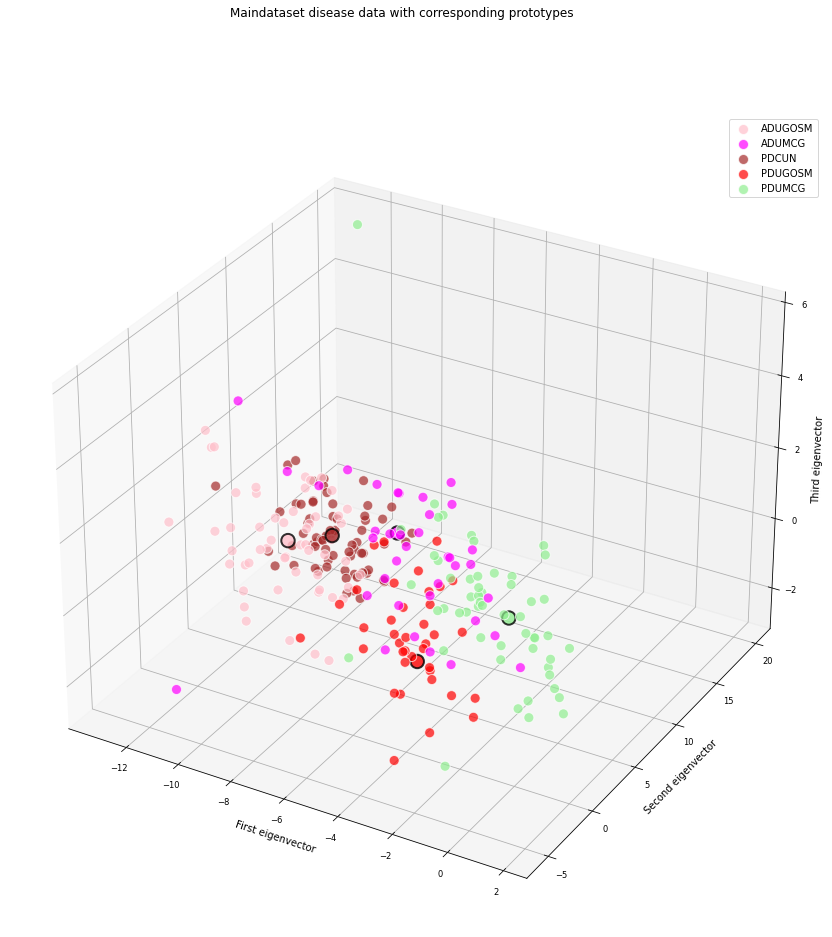

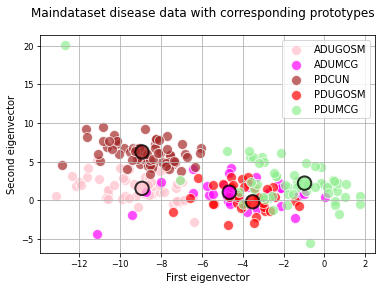

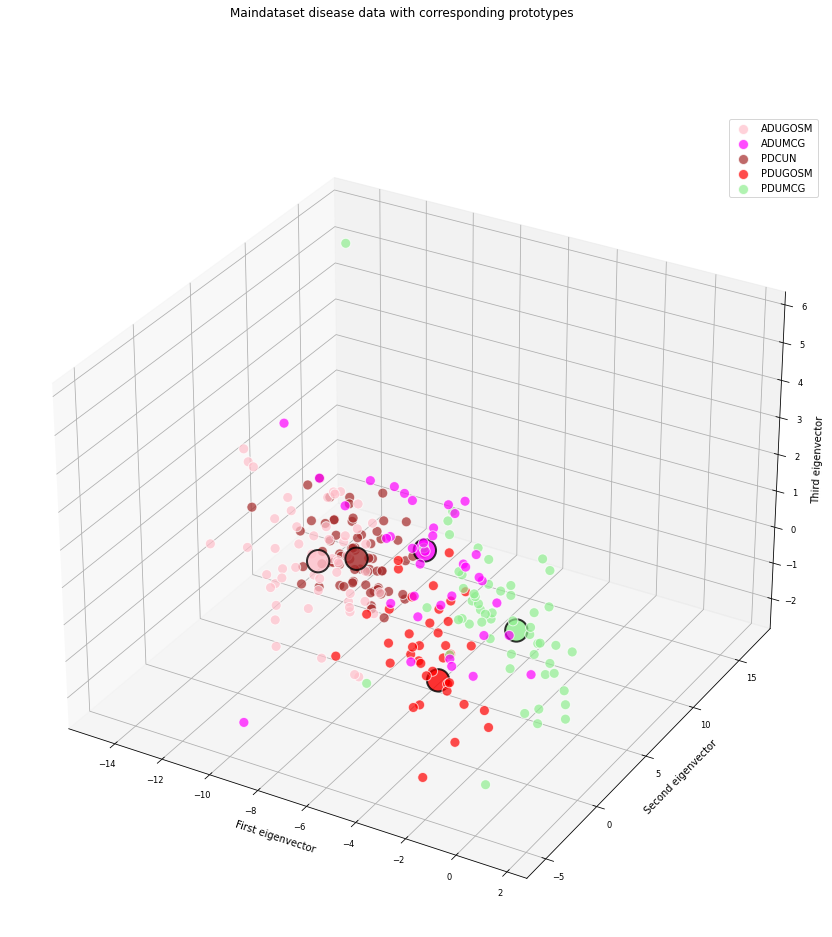

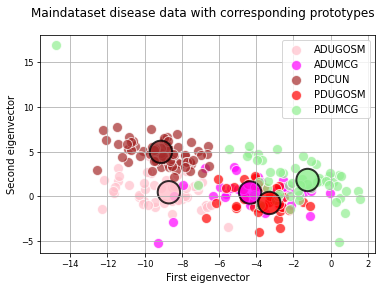

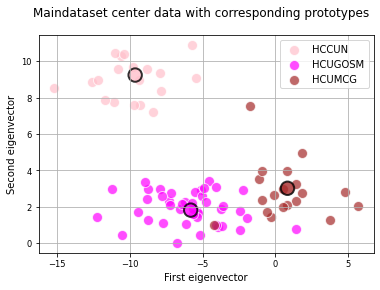

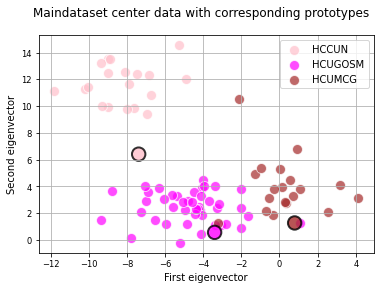

In [38]:
visualizeSinglemodeld(modeld,scalarId,datanoHC,labels4class,modeld.eigenvalues_,modeld.eigenvectors_,modeld.prototypes_)

visualizeSinglemodeld2(modeld,scalarId,datanoHC,labels4class,modeld.eigenvalues_,modeld.eigenvectors_,modeld.prototypes_)



averageprototype(modeld,scalar,datanoHC,labels4class,eigenvaluesdisease,eigenvectorsdisease,average_prototype_disease)

averageprototype2(modeld,scalar,datanoHC,labels4class,eigenvaluesdisease,eigenvectorsdisease,average_prototype_disease)


##########################center####################################

visualizeSinglemodelc(modelc,scalarIc,centerdata1,centerlabels1,modelc.eigenvalues_,modelc.eigenvectors_,modelc.prototypes_)

averageprototypec(modelc,scalarIc,centerdata1,centerlabels1,eigenvaluescenter,eigenvectorscenter,average_prototype_center)

# visualize_diseaseaverage(diseasemodel[0][2],scalars2[0][2],datamatrix1[0][2],labelmatrix1[0][2],eigenvaluesdisease,eigenvectorsdisease)
#eigenvectorc  eigenvaluec eigenvectord eigenvalued

#visualizeSinglemodeld(diseasemodel[0][3],scalars2[0][3],datamatrix1[0][3],labelmatrix1[0][3],diseasemodel[0][3].eigenvalues_,diseasemodel[0][3].eigenvectors_,diseasemodel[0][3].prototypes_)
#averageprototype(centermodel[0][2],scalars1[0][2],finaldatacenter,finalcenterlabels,eigenvaluesdisease,eigenvectorsdisease,average_prototype_center)

# Trained on 2 class but visualised with 6 class, below list
#visualize_diseaseaverage(diseasemodel[0][2],scalars2[0][2],datamatrix1[0][2],labelmatrix1[0][2],eigenvaluesdisease,eigenvectorsdisease)
#visualize_disease(diseasemodel[0][2],scalars2[0][2],datamatrix1[0][2],labelmatrix1[0][2])

## visualize models 6 class

In [39]:
# Plot the eigenvalues of the eigenvectors of the relevance matrix.
def ploteigenvalues(eigenvalues,eigenvectors,average_lambda,d):
    fig, ax = plt.subplots()
    fig.suptitle("Eigen values with correction "+d+ " main data")
    ax.bar(range(0, len(eigenvalues)), eigenvalues)
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('eigenvalues'+d+'.eps', format='eps')
    fig.savefig('eigenvalues'+d+'.png')
    #fig.savefig('eigenvalues+d+.svg", format ='svg', dpi=1200)


    # Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
    fig, ax = plt.subplots()
    fig.suptitle("First Eigenvector with correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[0, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Firsteigenvector'+d+'.eps', format='eps')
    fig.savefig('Firsteigenvector'+d+'.png')
    
    

    
    
    fig, ax = plt.subplots()
    fig.suptitle("Second Eigenvector with correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[1, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Secondeigenvector'+d+'.eps', format='eps')
    fig.savefig('Secondeigenvector'+d+'.png')
    
    
    
    fig, ax = plt.subplots()
    fig.suptitle("Third Eigenvector with correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[2, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Third'+d+'.eps', format='eps')
    fig.savefig('Third'+d+'.png')
    # The relevance matrix is available after fitting the model.
    
    fig, ax = plt.subplots()
    relevance_matrix = average_lambda
    fig.suptitle("Relevance Matrix Diagonal with correction " +d+ " main data")
    ax.bar(feature_names, np.diagonal(relevance_matrix))
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('relevancematrix'+d+'.eps', format='eps')
    fig.savefig('relevancematrix'+d+'.png')

In [40]:
# Plot the eigenvalues of the eigenvectors of the relevance matrix.
def ploteigenvalueswithout(eigenvalues,eigenvectors,average_lambda,d):
    fig, ax = plt.subplots()
    fig.suptitle("Eigen values without correction "+d+ " main data")
    ax.bar(range(0, len(eigenvalues)), eigenvalues)
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('eigenvalues'+d+'.eps', format='eps')
    fig.savefig('eigenvalues'+d+'.png')
    #fig.savefig('eigenvalues+d+.svg", format ='svg', dpi=1200)


    # Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
    fig, ax = plt.subplots()
    fig.suptitle("First Eigenvector without correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[0, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Firsteigenvector'+d+'.eps', format='eps')
    fig.savefig('Firsteigenvector'+d+'.png')
    
    fig, ax = plt.subplots()
    fig.suptitle("Second Eigenvector without correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[1, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Secondeigenvector'+d+'.eps', format='eps')
    fig.savefig('Secondeigenvector'+d+'.png')
    
    
    
    
    fig, ax = plt.subplots()
    fig.suptitle("Third Eigenvector without correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[2, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Third'+d+'.eps', format='eps')
    fig.savefig('Third'+d+'.png')
    
    
    fig, ax = plt.subplots()
    # The relevance matrix is available after fitting the model.
    relevance_matrix = average_lambda
    fig.suptitle("Relevance Matrix Diagonal without correction " +d+ " main data")
    ax.bar(feature_names, np.diagonal(relevance_matrix))
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('relevancematrix'+d+'.eps', format='eps')
    fig.savefig('relevancematrix'+d+'.png')

In [41]:
## average 

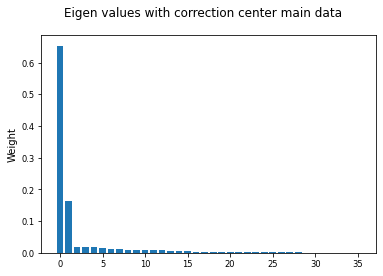

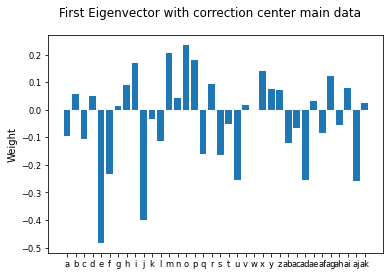

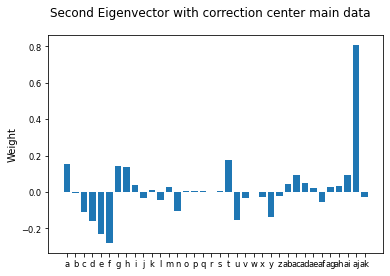

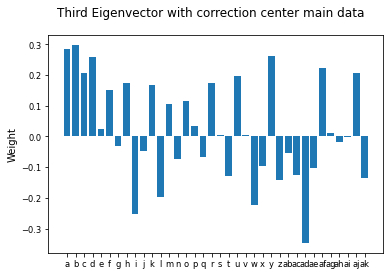

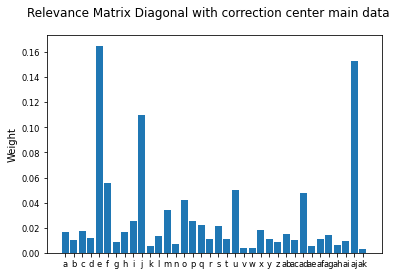

In [42]:
ploteigenvalues(eigenvaluescenter,eigenvectorscenter,average_lambda_center,'center')

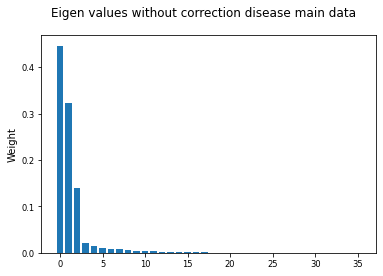

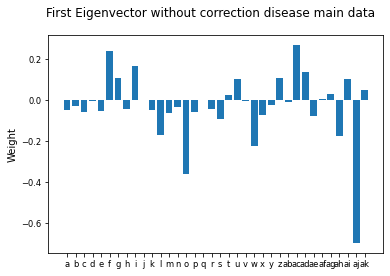

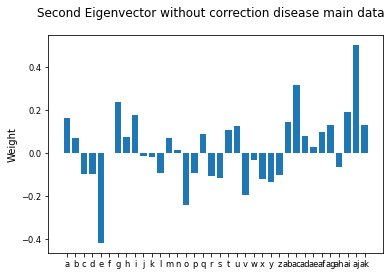

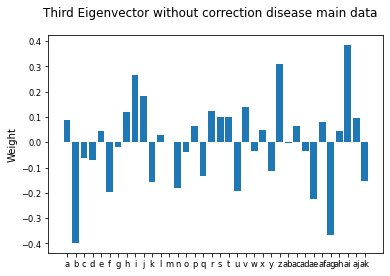

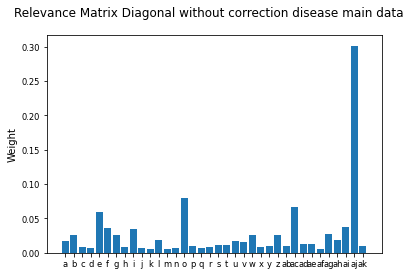

In [43]:
ploteigenvalueswithout(modeld.eigenvalues_,modeld.eigenvectors_,modeld.lambda_,'disease')

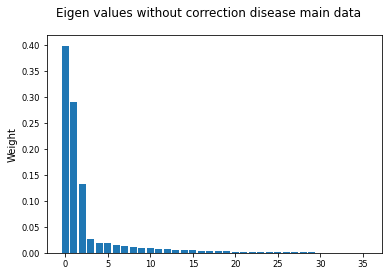

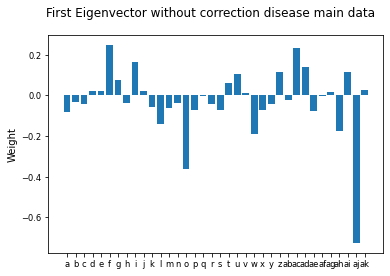

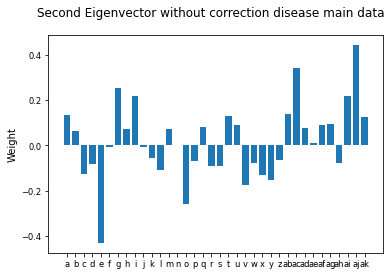

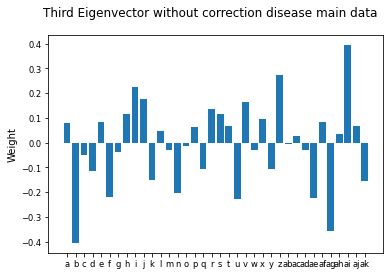

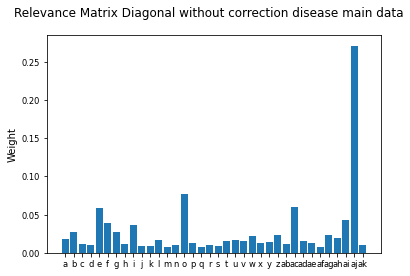

In [44]:
ploteigenvalueswithout(eigenvaluesdisease,eigenvectorsdisease,average_lambda_disease,'disease')

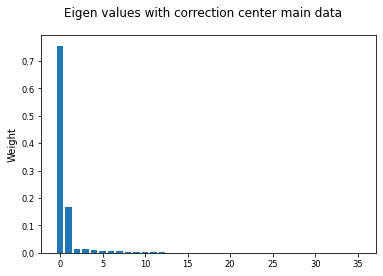

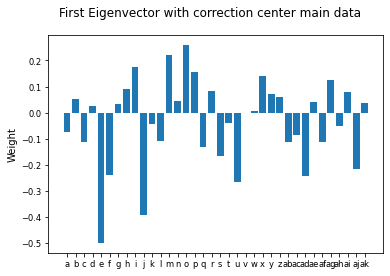

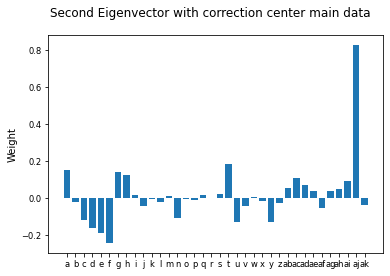

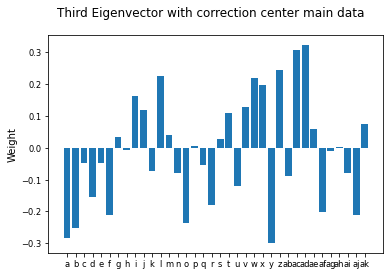

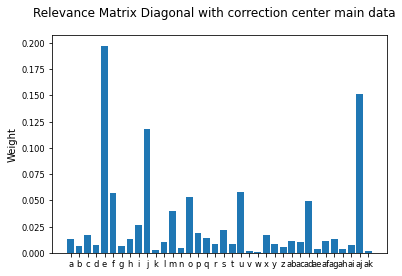

In [45]:
ploteigenvalues(modelc.eigenvalues_,modelc.eigenvectors_,modelc.lambda_,'center')